In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

def plot_cols(column_list, ylabel=''):
    """Plot columns from df. Columns to plot must be in
    column_list."""
    
    n = len(column_list)

    fig, ax = plt.subplots(n, figsize=(10,3*n), tight_layout=True, sharex=True)

    for i, col in enumerate(column_list):
        ax[i].plot(df.index, df[col], label=col)
        ax[i].legend(loc='upper right')
        ax[i].set(ylabel=ylabel)
        
    return fig, ax

In [6]:
# Import each file individually as a dataframe and append it to a list of dataframes


infiles = ["../../raw_data/Catalina-Jemez/MC_Pit1/mc_pit1_2010.csv", 
           "../../raw_data/Catalina-Jemez/MC_Pit1/mc_pit1_2011.csv", 
           "../../raw_data/Catalina-Jemez/MC_Pit1/mc_pit1_2012.csv", 
           "../../raw_data/Catalina-Jemez/MC_Pit1/mc_pit1_2013.csv", 
           "../../raw_data/Catalina-Jemez/MC_Pit1/mc_pit1_2014.csv", 
           "../../raw_data/Catalina-Jemez/MC_Pit1/mc_pit1_2015.csv", 
           "../../raw_data/Catalina-Jemez/MC_Pit1/mc_pit1_2016.csv", 
           "../../raw_data/Catalina-Jemez/MC_Pit1/mc_pit1_2018.csv",
           "../../raw_data/Catalina-Jemez/MC_Pit1/MC1co2o2_2013.csv",  
           "../../raw_data/Catalina-Jemez/MC_Pit1/MC1co2o2_2014.csv",  
           "../../raw_data/Catalina-Jemez/MC_Pit1/MC1co2o2_2015.csv",  
           "../../raw_data/Catalina-Jemez/MC_Pit1/MC1co2o2_2016.csv",  
           "../../raw_data/Catalina-Jemez/MC_Pit1/MC1co2o2_2017.csv",  
           "../../raw_data/Catalina-Jemez/MC_Pit1/Redox_MC_Pit1_2015.csv", 
           "../../raw_data/Catalina-Jemez/MC_Pit1/Redox_MC_Pit1_2016.csv", 
           "../../raw_data/Catalina-Jemez/MC_Pit1/Redox_MC_Pit1_2017.csv", 
           "../../raw_data/Catalina-Jemez/MC_Pit1/Redox_MC_Pit1_2018.csv"]

# Lists of all dataframes
df_list = []

for infile in tqdm(infiles):
    df = pd.read_csv(infile, na_values=['NAN', -9999],  parse_dates=[0], 
                     index_col=0, skiprows=[1]) # skiprows=[1] skips the 1th row (0-indexed)
    df_list.append(df)
    
prism_path = "../../raw_data/Catalina-Jemez/Catalina-Jemez_MC_PRISM.csv"
ppt = pd.read_csv(prism_path, na_values=['NAN',-9999,-99999], skiprows=11, 
                  parse_dates=[0], index_col=0, names=['PRISM_precip.mm']) 
ppt['PRISM_precip.mm'] = pd.to_numeric(ppt['PRISM_precip.mm'])

In [7]:
columns=['SoilMoisture_12cm.m3m3', 'Decagon5TETemp_12cm.deg.C', 'BulkEC_12cm.dS/m',
            'SoilMoisture_37cm.m3m3', 'Decagon5TETemp_37cm.deg.C', 'BulkEC_37cm.dS/m',
            'SoilMoisture_57cm.m3m3', 'Decagon5TETemp_57cm.deg.C', 'BulkEC_57cm.dS/m',
            'Voltage_12cm.mV', 'Voltage_23cm.mV', 'ApogeeTemp_2cm.deg.C','ApogeeTemp_10cm.deg.C',
            'ApogeeTemp_30cm.deg.C', 'ApogeeTemp_60cm.deg.C', 'O2_2cm.percent.0-100', 
            'O2_10cm.percent.0-100', 'O2_30cm.percent.0-100', 'O2_60cm.percent.0-100',
            'CO2_2cm.ppm', 'CO2_10cm.ppm', 'CO2_30cm.ppm', 'CO2_60cm.ppm', 
            'ReductionPotential_5cm.mV','ReductionPotential_10cm.mV','ReductionPotential_30cm.mV',
            'ReductionPotential_60cm.mV',]

# Concatenate all individual files to a single dataframe
df = pd.concat(df_list)
df.columns = columns

# Resample everything to hourly averages since certain 
# sensors are measured on different schedules
df.sort_index(inplace=True) # Sort first
df = df.resample('1H').mean()
df
# Add on up-sampled PRISM data
# (resample daily to hourly, using the nearest value, then
#  add on as new column to df)
hourly_ppt = ppt.resample('1H').nearest()
df.loc[hourly_ppt.index, 'PRISM_precip.mm'] = hourly_ppt['PRISM_precip.mm']

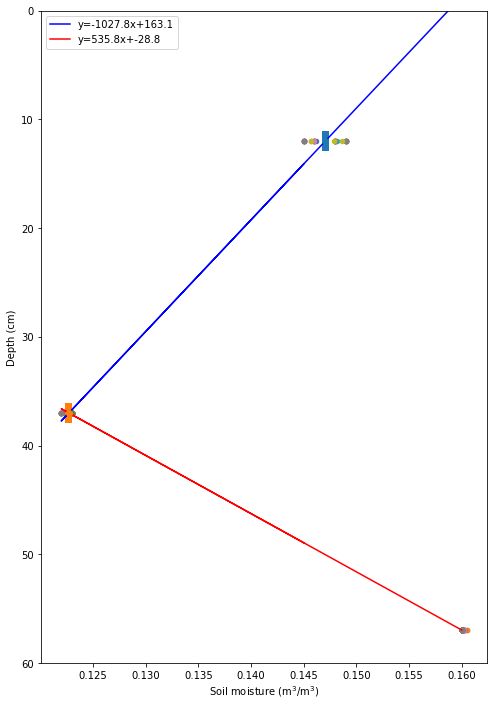

In [8]:
#  My basic idea here is to create a piecewise function that predicts the soil moisture values based on the data for each day
#  The problem I am having here is that my 30cm values are just for this
#  single calculation (range(24) corresponds to 1 day of data), so I need to loop through the 
#  data and calculate a new best fit line for each day and use the daily best fit lines to 
#  calculate respective daily values for the soil moisture at 30cm. However, this will 
#  produce daily averages, so the data will lose some variability. This might be necessary though, since 
#  I don't know how we can predict values without doing some kind of averaging that will reduce variability.
#  Also, I am having trouble plotting error bars or 95% confidence intervals. For some reason my standard errors are the same 
#  for the soil moisture values at each depth, which I don't think should be the case, based on the disctirbution of 
#  points shown from the scatter plot (it looks like 12cm should have a higher standard error)
import scipy.stats as st
import numpy as np
import pandas as pd

sm_df = df[[col for col in df.columns if 'SoilMoisture' in col]]
#sm_df=sm_df.drop(columns='SoilMoisture_30cm.m3m3')
fig, ax = plt.subplots(figsize=(8,12))
n=100  #Starting point
for i in range(48):
    ax.scatter(sm_df.iloc[i+n, :], [12, 37, 57], s=20)
    x_12=np.mean(sm_df['SoilMoisture_12cm.m3m3'].iloc[n:i+n])
    x_12stdev=np.std(sm_df['SoilMoisture_12cm.m3m3'].iloc[n:i+n])
    x_12SE=x_12stdev/np.sqrt(len(sm_df['SoilMoisture_12cm.m3m3'].iloc[n:i+n]))
    x_37=np.mean(sm_df['SoilMoisture_37cm.m3m3'].iloc[n:i+n])
    x_37stdev=np.std(sm_df['SoilMoisture_37cm.m3m3'].iloc[n:i+n])
    x_37SE=x_12stdev/np.sqrt(len(sm_df['SoilMoisture_37cm.m3m3'].iloc[n:i+n]))
    x_57=np.mean(sm_df['SoilMoisture_57cm.m3m3'].iloc[n:i+n])
    x_57stdev=np.std(sm_df['SoilMoisture_57cm.m3m3'].iloc[n:i+n])
    x_57SE=x_12stdev/np.sqrt(len(sm_df['SoilMoisture_57cm.m3m3'].iloc[n:i+n]))
    #m, b = np.polyfit([x_12, x_37, x_57], [12, 37, 57], 1)
    #m1, b1 = np.polyfit([x_12, x_37], [12, 37], 1)
    #m2, b2 = np.polyfit([x_37, x_57], [57, 37], 1)

    m1=25/(x_37-x_12)
    b1=12-m1*x_12
    m2=20/(x_57-x_37)
    b2=37-m2*x_37
    df['SoilMoisture_30cm.m3m3']=(30-b1)/m1
ax.set(xlabel='Soil moisture (m$^3$/m$^3$)', ylabel="Depth (cm)", ylim=[60,0])
ax.plot(sm_df.iloc[i+n, :], m1*sm_df.iloc[i+n, :] + b1, label="y={0:.1f}x+{1:.1f}".format(m1,b1), c='b', lw=1.5)
ax.plot(sm_df.iloc[i+n, :], m2*sm_df.iloc[i+n, :] + b2, label="y={0:.1f}x+{1:.1f}".format(m2,b2), c='r', lw=1.5)
#ax.plot(st.t.interval(0.95, len(sm_df.iloc[i+n, :])-1, loc=np.mean(sm_df.iloc[i+n, :]), scale=st.sem(sm_df.iloc[i+n, :])))
#plot_ci_manual(t, s_err, n, x, x2, y2, ax=ax)
e=.000329
plt.errorbar(x_12, 12, xerr=e, fmt='o', lw=20)
plt.errorbar(x_37, 37, xerr=e, fmt='o', lw=20)

plt.legend()


12    0.197140
37    0.205100
57    0.247635
dtype: float64

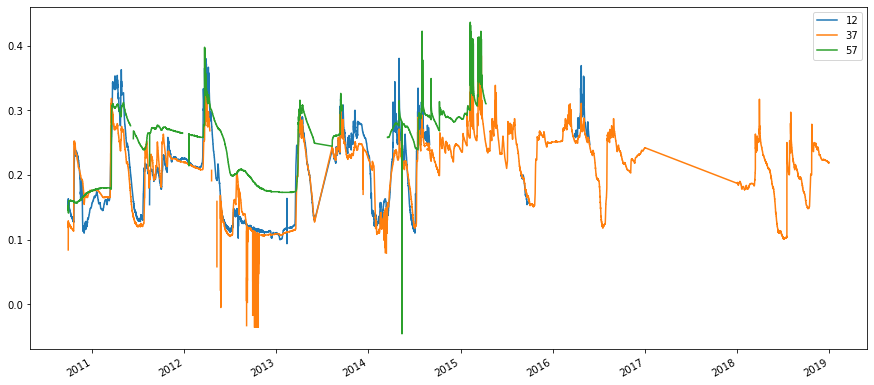

In [9]:
#Determine relationship between soil moisture and depth
df12=df['SoilMoisture_12cm.m3m3']
df37=df['SoilMoisture_37cm.m3m3']
df57=df['SoilMoisture_57cm.m3m3']
pieces = {12: df12, 37: df37, 57: df57}
depth_df=pd.concat(pieces, join='inner', keys=[12, 37, 57])
depth_df=depth_df[depth_df<2]
time_group=depth_df.groupby(level=1)
fig, ax = plt.subplots(figsize=(15,7))
# use unstack()
depth_df.groupby(level=(1,0)).mean().unstack().plot(ax=ax)
depth_df.groupby(level=(0)).mean()

In [ ]:
def plot_ci_manual(t, s_err, n, x, x2, y2, ax=None):
    """Return an axes of confidence bands using a simple approach.

    Notes
    -----
    .. math:: \left| \: \hat{\mu}_{y|x0} - \mu_{y|x0} \: \right| \; \leq \; T_{n-2}^{.975} \; \hat{\sigma} \; \sqrt{\frac{1}{n}+\frac{(x_0-\bar{x})^2}{\sum_{i=1}^n{(x_i-\bar{x})^2}}}
    .. math:: \hat{\sigma} = \sqrt{\sum_{i=1}^n{\frac{(y_i-\hat{y})^2}{n-2}}}

    References
    ----------
    .. [1] M. Duarte.  "Curve fitting," Jupyter Notebook.
       http://nbviewer.ipython.org/github/demotu/BMC/blob/master/notebooks/CurveFitting.ipynb

    """
    if ax is None:
        ax = plt.gca()

    ci = t * s_err * np.sqrt(1/n + (x2 - np.mean(x))**2 / np.sum((x - np.mean(x))**2))
    ax.fill_between(x2, y2 + ci, y2 - ci, color="#b9cfe7", edgecolor="")

    return ax

y = np.array(sm_df.iloc[i+n, :])
x = np.array([12, 37, 57])

# Modeling with Numpy
def equation(a, b):
    """Return a 1D polynomial."""
    return np.polyval(a, b) 

p, cov = np.polyfit(x, y, 1, cov=True)                     # parameters and covariance from of the fit of 1-D polynom.
y_model = equation(p, x)                                   # model using the fit parameters; NOTE: parameters here are coefficients

# Statistics
n = y.size                                           # number of observations
m = p.size                                                 # number of parameters
dof = n - m                                                # degrees of freedom
t = st.t.ppf(0.975, n - m)                              # used for CI and PI bands

# Estimates of Error in Data/Model
resid = y - y_model                           
chi2 = np.sum((resid / y_model)**2)                        # chi-squared; estimates error in data
chi2_red = chi2 / dof                                      # reduced chi-squared; measures goodness of fit
s_err = np.sqrt(np.sum(resid**2) / dof)                    # standard deviation of the error

fig, ax = plt.subplots(figsize=(8, 6))

# Data
ax.plot(
    x, y, "o", color="#b9cfe7", markersize=8, 
    markeredgewidth=1, markeredgecolor="b", markerfacecolor="None"
)

# Fit
ax.plot(x, y_model, "-", color="0.1", linewidth=1.5, alpha=0.5, label="Fit")  

x2 = np.linspace(np.min(x), np.max(x), 100)
y2 = equation(p, x2)

# Confidence Interval (select one)
plot_ci_manual(t, s_err, n, x, x2, y2, ax=ax)
#plot_ci_bootstrap(x, y, resid, ax=ax)
x_12stdev
x_12SE
#x_37SE

In [ ]:
import seaborn
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress([x_12, x_37], [12, 37])
ax=seaborn.regplot([x_12, x_37], [12, 37],line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})
ax.legend()
plt.show()